# LangGraph

In [1]:
import os
from google.colab import userdata
os.environ["OPENAI_API_KEY"] = userdata.get("openai_api_key")

In [3]:
!pip install uv > /dev/null
!uv pip install langchain langchain-openai langgraph

Using Python 3.12.12 environment at: /usr
Audited 3 packages in 158ms


In [170]:
import io
import random
from PIL import Image
from pydantic import BaseModel
from typing import TypedDict, Literal, List, Annotated
from langchain_core.messages import (
    BaseMessage, HumanMessage, SystemMessage, RemoveMessage
)
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode, tools_condition

## Graph

### State

In [11]:
class State(TypedDict):
    message: str

In [6]:
x = State(message="hello")

In [9]:
x["message"]

'hello'

In [10]:
def test(state: State) -> None:
    ...

In [ ]:
test({"mess": "hello"})

### Nodes

In [12]:
def node_1(state: State) -> State:
    print("node_1")
    return {"message": state["message"] + " is"}

In [13]:
def node_2(state: State) -> State:
    print("node_2")
    return {"message": state["message"] + " happy"}

In [14]:
def node_3(state: State) -> State:
    print("node_3")
    return {"message": state["message"] + " sad"}

### Edge

In [18]:
def decide_mood(state: State) -> Literal["node_2", "node_3"]:
    return "node_2" if random.random() < 0.5 else "node_3"

### Graph

In [25]:
builder = StateGraph(State)

In [26]:
(
    builder
    .add_node("node_1", node_1)
    .add_node(node_2)
    .add_node(node_3)
)

In [23]:
print(START)

__start__


In [27]:
(
    builder
    .add_edge(START, "node_1")
    .add_conditional_edges("node_1", decide_mood)
    .add_edge("node_2", END)
    .add_edge("node_3", END)
)

In [28]:
graph = builder.compile()

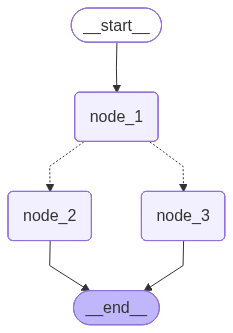

In [38]:
png_bytes = graph.get_graph(xray=True).draw_mermaid_png()
Image.open(io.BytesIO(png_bytes))

In [49]:
graph.invoke({"message": "Pepito"})

node_1
node_2


{'message': 'Pepito is happy'}

## Ejemplos

### LLM Basico

In [54]:
["hello", "world"] + ["good", "bye"]

['hello', 'world', 'good', 'bye']

- State

In [85]:
def extend_messages(prev: List[str], new: List[str]) -> List[str]:
    return prev + new

class PydanticState(BaseModel):
    messages: Annotated[List[BaseMessage], extend_messages]

- Node

In [86]:
model = ChatOpenAI(model="gpt-4o-mini")

def agent_node(state: PydanticState) -> PydanticState:
    response = model.invoke(state.messages)
    response.name = "Peter"
    return PydanticState(messages=[response])

- Graph

In [87]:
builder = (
    StateGraph(PydanticState)
    .add_node(agent_node)
    .add_edge(START, "agent_node")
    .add_edge("agent_node", END)
)

In [88]:
graph = builder.compile()

In [70]:
state = PydanticState(messages=[HumanMessage("Hello")])

In [75]:
state = graph.invoke(state)
print(state["messages"][-1].content)

Hello! How can I help you today?


In [76]:
state = PydanticState(
    messages=(
        state["messages"] +
        [HumanMessage(content="Who was Albert Einstein")]
        )
)

In [77]:
state = graph.invoke(state)
print(state["messages"][-1].content)

Albert Einstein was a theoretical physicist born on March 14, 1879, in Ulm, Germany. He is best known for developing the theory of relativity, particularly the equation \(E=mc^2\), which describes the equivalence of mass and energy. This equation has become one of the most famous equations in physics.

Einstein's work fundamentally changed our understanding of space, time, and gravity. In 1905, often referred to as his "miracle year," he published four groundbreaking papers that included his theories on the photoelectric effect (which later earned him the Nobel Prize in Physics in 1921), Brownian motion, special relativity, and mass-energy equivalence.

In 1915, he presented his general theory of relativity, which expanded on his earlier work and provided a new way of understanding gravitation as the curvature of spacetime caused by mass. Einstein's theories have had a profound impact on modern physics and cosmology.

Aside from his scientific contributions, Einstein was also known for

In [78]:
state

{'messages': [HumanMessage(content='Hello', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 8, 'total_tokens': 17, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CekO4CRCxa4rWJzLRdhRrfVhrRHw4', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, name='Peter', id='run--de480822-5c5b-40c9-9f32-16f8f3d3684a-0', usage_metadata={'input_tokens': 8, 'output_tokens': 9, 'total_tokens': 17, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
  AIMessage(content='Hello! How can I help you today?', addition

### Memoria

In [80]:
builder = (
    StateGraph(PydanticState)
    .add_node(agent_node)
    .add_edge(START, "agent_node")
    .add_edge("agent_node", END)
)

In [91]:
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

In [92]:
config = {"configurable": {"thread_id": "1"}}
graph.invoke(
    PydanticState(
        messages=[HumanMessage(content="Hello, I'm Juan")]
        ),
    config
    )

{'messages': [HumanMessage(content="Hello, I'm Juan", additional_kwargs={}, response_metadata={}),
  AIMessage(content='Hello, Juan! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 11, 'total_tokens': 22, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-Cekd4pd7MCi3UAe78mFXLwb06mLto', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, name='Peter', id='run--4548b971-d343-4e4d-bcb3-15aa5210ffe6-0', usage_metadata={'input_tokens': 11, 'output_tokens': 11, 'total_tokens': 22, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

In [93]:
config = {"configurable": {"thread_id": "1"}}
graph.invoke(
    PydanticState(
        messages=[HumanMessage(content="What's my name?")]
        ),
    config
    )

{'messages': [HumanMessage(content="Hello, I'm Juan", additional_kwargs={}, response_metadata={}),
  AIMessage(content='Hello, Juan! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 11, 'total_tokens': 22, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-Cekd4pd7MCi3UAe78mFXLwb06mLto', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, name='Peter', id='run--4548b971-d343-4e4d-bcb3-15aa5210ffe6-0', usage_metadata={'input_tokens': 11, 'output_tokens': 11, 'total_tokens': 22, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
  HumanMessage(content="What's my name?", ad

### Memoria Resumen

In [95]:
# class PydanticState(TypedDict):
#    messages: Annotated[List[BaseMessage], extend_messages]
#    summary: str

- State

In [147]:
class SummaryState(MessagesState):
    summary: str

- Nodes

In [148]:
model = ChatOpenAI(model="gpt-4o-mini")

def agent_node(state: SummaryState) -> SummaryState:
    summary = state.get("summary", "")
    if summary:
        messages = [
            SystemMessage(
                f"Summary of previous conversation: {summary}"
                ),
            *state["messages"]
        ]
    else:
        messages = state["messages"]
    response = model.invoke(messages)
    return {"messages": [response]}

In [149]:
summary_model = ChatOpenAI(model="gpt-4o-mini")
def summarizer_node(state: SummaryState) -> SummaryState:
    summary = state.get("summary", "")
    if summary:
        summary_message = f"""
        This is the summary of the previous conversation:
        {summary}
        Extend the summary by taking into account the following new messages:
        """
    else:
        summary_message = """
        Create a summary of the following messages, taking into account user details
        """
    messages = [SystemMessage(content=summary_message), *state["messages"]]
    response = summary_model.invoke(messages)
    return {"summary": response.content}

In [150]:
def remove_messages(state: SummaryState) -> SummaryState:
    delete_messages = [
        RemoveMessage(id=message.id)
        for message in state["messages"]#[:-2]
    ]
    return {"messages": delete_messages}

- Edge

In [151]:
def should_continue(
    state: SummaryState
    ) -> Literal["__end__", "summarizer_node"]:
    if len(state["messages"]) > 6:
        return "summarizer_node"
    else:
        return END

- Graph

In [152]:
builder = (
    StateGraph(SummaryState)
    .add_node(agent_node)
    .add_node(summarizer_node)
    .add_node(remove_messages)
    .add_edge(START, "agent_node")
    .add_conditional_edges("agent_node", should_continue)
    .add_edge("summarizer_node", "remove_messages")
    .add_edge("remove_messages", END)
)

In [153]:
memory = MemorySaver()

In [154]:
graph = builder.compile(checkpointer=memory)

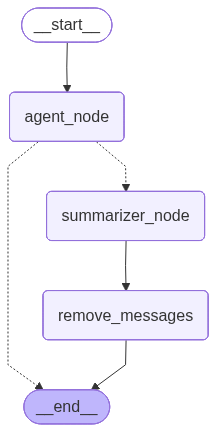

In [155]:
png_bytes = graph.get_graph(xray=True).draw_mermaid_png()
Image.open(io.BytesIO(png_bytes))

In [156]:
config = {"configurable": {"thread_id": "1"}}
graph.invoke({"messages": [HumanMessage(content="Hello, I'm Juan")]}, config)

{'messages': [HumanMessage(content="Hello, I'm Juan", additional_kwargs={}, response_metadata={}, id='9f8bb30f-763d-4b95-bfbb-8d09ec227818'),
  AIMessage(content='Hello Juan! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 11, 'total_tokens': 21, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CelYOAIAPErFyb7f9BPHXRGvswYC7', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--28d38d9a-f344-4eef-8141-db129dca5d56-0', usage_metadata={'input_tokens': 11, 'output_tokens': 10, 'total_tokens': 21, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

In [157]:
graph.invoke({"messages": [HumanMessage(content="I like cats")]}, config)

{'messages': [HumanMessage(content="Hello, I'm Juan", additional_kwargs={}, response_metadata={}, id='9f8bb30f-763d-4b95-bfbb-8d09ec227818'),
  AIMessage(content='Hello Juan! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 11, 'total_tokens': 21, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CelYOAIAPErFyb7f9BPHXRGvswYC7', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--28d38d9a-f344-4eef-8141-db129dca5d56-0', usage_metadata={'input_tokens': 11, 'output_tokens': 10, 'total_tokens': 21, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
  HumanMessage(c

In [158]:
graph.invoke({"messages": [HumanMessage(content="I like pizza")]}, config)

{'messages': [HumanMessage(content="Hello, I'm Juan", additional_kwargs={}, response_metadata={}, id='9f8bb30f-763d-4b95-bfbb-8d09ec227818'),
  AIMessage(content='Hello Juan! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 11, 'total_tokens': 21, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CelYOAIAPErFyb7f9BPHXRGvswYC7', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--28d38d9a-f344-4eef-8141-db129dca5d56-0', usage_metadata={'input_tokens': 11, 'output_tokens': 10, 'total_tokens': 21, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
  HumanMessage(c

In [159]:
graph.invoke({
    "messages": [HumanMessage(content="Which animal do I like?")]},
    config
    )

{'messages': [],
 'summary': 'You like cats! If there’s anything specific you’d like to discuss about them or any other topics, feel free to share!'}

In [160]:
graph.invoke({
    "messages": [HumanMessage(content="What is my name?")]},
    config
    )

{'messages': [HumanMessage(content='What is my name?', additional_kwargs={}, response_metadata={}, id='8d038012-0d07-46ce-a4ba-d98dde963f5e'),
  AIMessage(content="I don’t know your name since we haven't discussed it yet. If you'd like to share it, feel free to do so!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 47, 'total_tokens': 73, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CelYR5JIlVGfpLAXs95B4XCioaLEt', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--a347f157-4026-43c5-b17a-8de44b9ecee0-0', usage_metadata={'input_tokens': 47, 'output_tokens': 26, 'total_tokens': 73, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'outpu

In [161]:
graph.invoke({
    "messages": [HumanMessage(content="Remember that I'm Juan")]},
    config
    )

{'messages': [HumanMessage(content='What is my name?', additional_kwargs={}, response_metadata={}, id='8d038012-0d07-46ce-a4ba-d98dde963f5e'),
  AIMessage(content="I don’t know your name since we haven't discussed it yet. If you'd like to share it, feel free to do so!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 47, 'total_tokens': 73, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CelYR5JIlVGfpLAXs95B4XCioaLEt', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--a347f157-4026-43c5-b17a-8de44b9ecee0-0', usage_metadata={'input_tokens': 47, 'output_tokens': 26, 'total_tokens': 73, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'outpu

In [162]:
graph.invoke({
    "messages": [HumanMessage(content="Who am I? and what do I like?")]},
    config
    )

{'messages': [HumanMessage(content='What is my name?', additional_kwargs={}, response_metadata={}, id='8d038012-0d07-46ce-a4ba-d98dde963f5e'),
  AIMessage(content="I don’t know your name since we haven't discussed it yet. If you'd like to share it, feel free to do so!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 47, 'total_tokens': 73, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CelYR5JIlVGfpLAXs95B4XCioaLEt', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--a347f157-4026-43c5-b17a-8de44b9ecee0-0', usage_metadata={'input_tokens': 47, 'output_tokens': 26, 'total_tokens': 73, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'outpu

In [163]:
graph.invoke({
    "messages": [HumanMessage(content="Who am I? and what do I like?")]},
    config
    )

{'messages': [],
 'summary': "You are Juan, and you like cats! If there's anything specific you'd like to discuss about cats or any other topics, feel free to share!"}

### Tools

In [164]:
def multiply(a: float, b: float) -> float:
    """
    Multiplies two numbers.

    :param a: First number.
    :type a: float
    :param b: Second number.
    :type b: float
    :return: Result of the multiplication between a and b.
    :rtype: float
    """
    return a * b

In [165]:
def add(a: float, b: float) -> float:
    """
    Adds two numbers.

    :param a: First number.
    :type a: float
    :param b: Second number.
    :type b: float
    :return: Result of the sum between a and b.
    :rtype: float
    """
    return a + b


In [166]:
def divide(a: float, b: float) -> float:
    """
    Divides two numbers.

    :param a: First number.
    :type a: float
    :param b: Second number.
    :type b: float
    :return: Result of a divided by b.
    :rtype: float
    """
    return a / b

In [172]:
tools = [
    multiply, add, divide
]
model = ChatOpenAI(model="gpt-4o-mini").bind_tools(tools)

In [168]:
system_message = SystemMessage(
    "You're a helpful assisstant tasked to perform basic artithmetic operations."
)

In [169]:
def agent_node(state: MessagesState) -> MessagesState:
    return {"messages": [model.invoke([system_message, *state["messages"]])]}

In [179]:
tools_condition?

In [173]:
builder = (
    StateGraph(MessagesState)
    .add_node(agent_node)
    .add_node("tools", ToolNode(tools))
    #.add_node("tools2", ToolNode(tools))
    .add_edge(START, "agent_node")
    .add_conditional_edges("agent_node", tools_condition)
    .add_edge("tools", "agent_node")
)

In [174]:
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

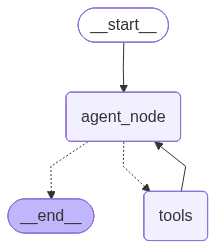

In [175]:
png_bytes = graph.get_graph(xray=True).draw_mermaid_png()
Image.open(io.BytesIO(png_bytes))

In [177]:
config = {"configurable": {"thread_id": "1"}}
graph.invoke(
    {"messages": [HumanMessage(content="What is 3828.100 + 188.55")]},
    config
    )

{'messages': [HumanMessage(content='What is 3828.100 + 188.55', additional_kwargs={}, response_metadata={}, id='1f20d5a2-ebd1-435b-b5fb-d3046ddfb3d6'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_70RpOU1ZD9eUYbNOMEyTfZTr', 'function': {'arguments': '{"a":3828.1,"b":188.55}', 'name': 'add'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 248, 'total_tokens': 270, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CelnDb1dB0O2sI8z3gdEQbMsC8Vou', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--6751cc19-c9b7-4db4-bc90-3deb46a12ca9-0', tool_calls=[{'name': 'add', 'args': {'a': 3828.1, 'b': 188.55}, 'id': 'call_70

In [178]:
graph.invoke(
    {"messages": [HumanMessage(content="What is 288.44 multiplied by 5 and divide that result by 388.566")]},
    config
    )

{'messages': [HumanMessage(content='What is 3828.100 + 188.55', additional_kwargs={}, response_metadata={}, id='1f20d5a2-ebd1-435b-b5fb-d3046ddfb3d6'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_70RpOU1ZD9eUYbNOMEyTfZTr', 'function': {'arguments': '{"a":3828.1,"b":188.55}', 'name': 'add'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 248, 'total_tokens': 270, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CelnDb1dB0O2sI8z3gdEQbMsC8Vou', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--6751cc19-c9b7-4db4-bc90-3deb46a12ca9-0', tool_calls=[{'name': 'add', 'args': {'a': 3828.1, 'b': 188.55}, 'id': 'call_70